In [1]:
%load_ext autoreload
%autoreload 2

In [13]:
import pyreadr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix

import shap
from utility.lib import prediction, confus_matrix_labels
from utility.get_data import get_lasso_selected_data

In [14]:
df_er, annot = get_lasso_selected_data()

In [15]:
# drop the target as this task in unsupervised
x = df_er.drop(columns=['er'])
y = df_er['er']

x = pd.DataFrame(x, columns=df_er.columns[:-1])


In [16]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

print(f' {len(y_train)} patients in train cohort')
print(f' {len(y_test)} patients in test cohort')

 132 patients in train cohort
 66 patients in test cohort


In [17]:
df_result = pd.DataFrame()

We trained 3 models : LogisticRegression, GradientBoosting and Classifier andRandomForestClassifier

In [18]:
# LR

from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(solver='liblinear',class_weight ='balanced')
logreg.fit(X_train, y_train)

log_score = prediction(logreg, X_test, y_test, 'logreg')
df_result = df_result.append(log_score, ignore_index=True)

predited = logreg.predict(X = X_test)
cm_lr = confusion_matrix(y_test, predited)

In [19]:
# Gxboost
from sklearn.ensemble import GradientBoostingClassifier

gx = GradientBoostingClassifier(n_estimators=50, learning_rate=1.0, max_depth=3, random_state=42)
gx.fit(X_train, y_train)

gx_score = prediction(gx, X_test, y_test, 'gx')
df_result = df_result.append(gx_score, ignore_index=True)

predited = gx.predict(X = X_test)
cm_gx = confusion_matrix(y_test, predited)

In [20]:
# rf

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=4, class_weight ='balanced')
rf.fit(X_train, y_train)

rf_score = prediction(rf, X_test, y_test,'RandomForestClassifier')
df_result = df_result.append(rf_score, ignore_index=True)

predited = rf.predict(X = X_test)
cm_rf = confusion_matrix(y_test, predited)

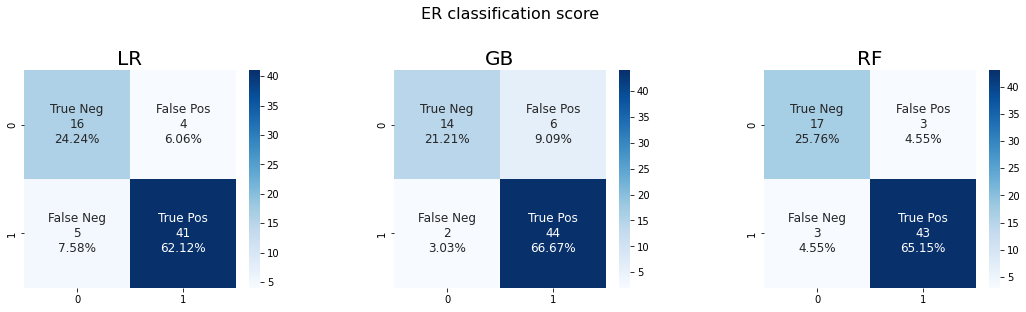

,model,accuracy,roc_auc,sensitivity,specificity,F1
0,logreg,0.863636,0.892391,0.891304,0.80,0.901099
1,gx,0.878788,0.894022,0.956522,0.70,0.916667
2,RandomForestClassifier,0.909091,0.897826,0.934783,0.85,0.934783


In [21]:
fig = plt.figure(figsize=(18,4))

ax1 = plt.subplot(1, 3, 1)
sns.heatmap(cm_lr, annot=confus_matrix_labels(cm_lr), fmt="", cmap='Blues', annot_kws={"size": 12}, ax = ax1)
ax1.set_title('LR', fontsize = 20)

ax2 = plt.subplot(1, 3, 2)
sns.heatmap(cm_gx, annot=confus_matrix_labels(cm_gx), fmt="", cmap='Blues', annot_kws={"size": 12}, ax = ax2)
ax2.set_title('GB', fontsize = 20)

ax3 = plt.subplot(1, 3, 3)
sns.heatmap(cm_rf, annot=confus_matrix_labels(cm_rf), fmt="", cmap='Blues', annot_kws={"size": 12}, ax = ax3)
ax3.set_title('RF', fontsize = 20)

fig.suptitle("ER classification score", fontsize=16, y=1.1)
plt.subplots_adjust(wspace=0.4)
plt.show()

df_result

The models performed well. The dataset is unbalance but we obtain good sensitivity/specificity and F1 score as well.

Lets try to explain the randomforst model with fetature importances and shap approaches

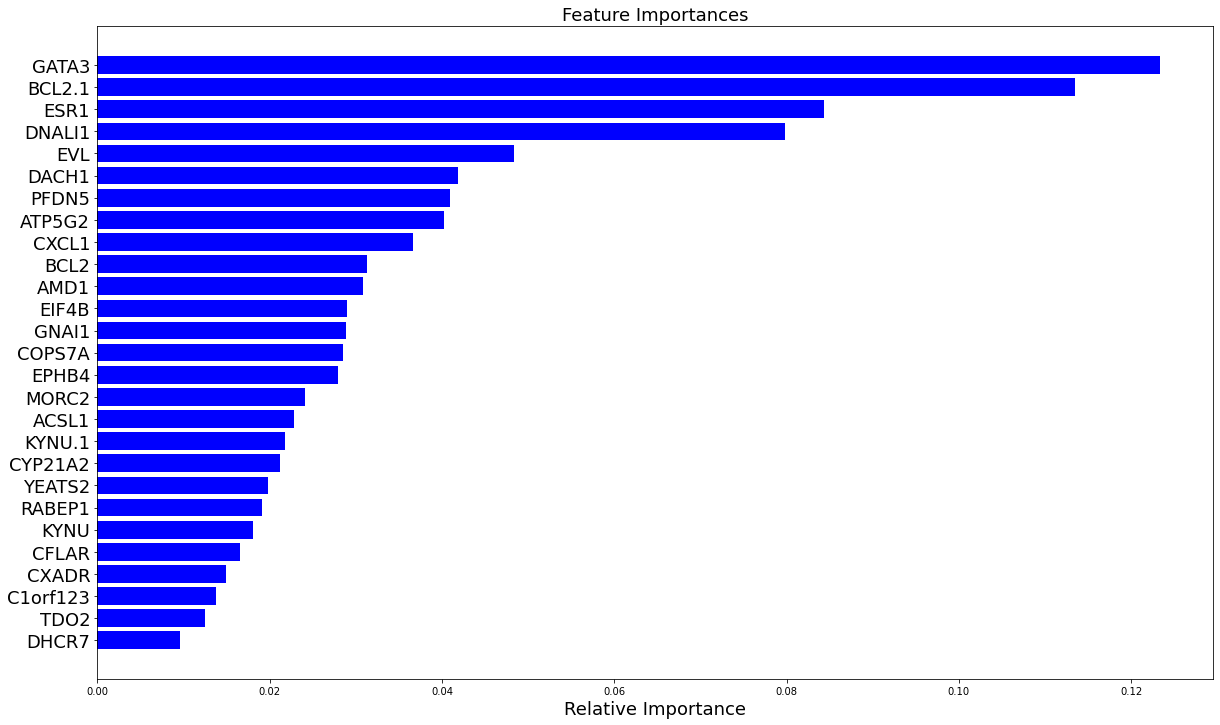

In [22]:
importances = rf.feature_importances_
indices = np.argsort(importances)

fig = plt.figure(figsize=(20,12))

genes = X_train.columns
plt.title('Feature Importances', fontsize=18)
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [genes[i] for i in indices], fontsize=18)
plt.xlabel('Relative Importance', fontsize=18)
plt.show()

We see here that the three top gene involve in er status is GATA3, BCL2.2 and ESR1. 
Now, we will se the model interpretability with shap

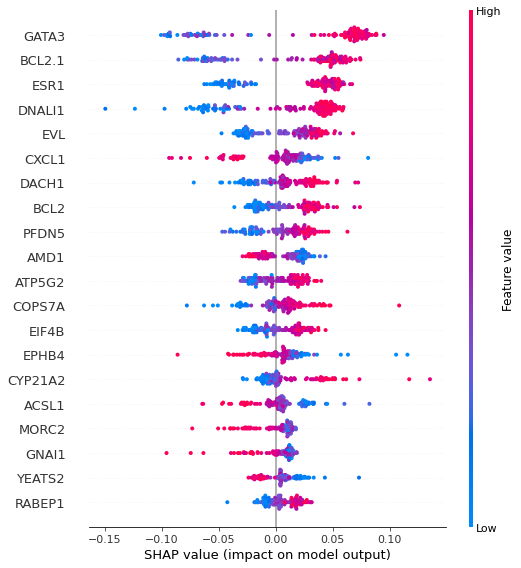

In [23]:
# tree model explainer
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_train, approximate=False, check_additivity=False)
# plot shap values
shap.summary_plot(shap_values[1], X_train)

# Conclusion

We found the same 3 top genes than before. Beside its seems that higher level of GATA3, BCL2.2 and ESR1 transcripts are associated with ER positive tumors.

Interestingly, both ESR1 is the Estrogen Receptor 1 and GATA3 (involve in ESR1 signaling) are both often mutated
in breast cancer. It's seems this markers can be use to differentiate ER positive and negative patient in most
of the case.

However, several aspect have not been take into account in this projet. The models we trained had quite higth predictive power but we did not :

- Perform cross validation to asssess preformances stability over different fold
- Test ours models on external validation cohort to assess performance on external patient

We also just try LASSO data feature selection along others (RFE, DGE) used to select relevant gene in transcriptomic study and we did not perform model optimization.





